In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [15]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [16]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

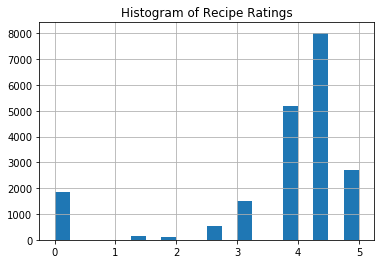

In [17]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [18]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [6]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Around 5-7 mins. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

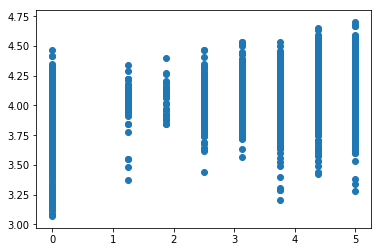

In [20]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [21]:
svr.score(X, Y)

-0.003978314483867651

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'aut

array([-0.01787926, -0.02916288, -0.02841122, -0.03767394, -0.01735362])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

# Exploring the Data

First let's code the data as follows:
>=3.5 positive review
3-4 neutral review
<3 negative review

In [28]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [3]:
#might be better to create a categorical variable that includes neutral states
rating_cat=[]

for row in raw_data['rating']:
    if row >= 4.375:
        rating_cat.append(1)
    elif row < 4.375:
        rating_cat.append(0)

raw_data['rating_cat'] = rating_cat
            
            
#quick check
print(raw_data['rating_cat'])

0        0
1        1
2        0
3        1
4        0
5        1
6        1
7        0
8        1
9        0
10       0
11       1
12       1
13       1
14       0
15       1
16       0
17       1
18       1
19       1
20       1
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       1
29       1
        ..
20022    1
20023    0
20024    1
20025    1
20026    1
20027    1
20028    0
20029    0
20030    0
20031    1
20032    1
20033    1
20034    1
20035    0
20036    1
20037    0
20038    0
20039    0
20040    1
20041    0
20042    0
20043    1
20044    0
20045    0
20046    0
20047    0
20048    1
20049    1
20050    1
20051    1
Name: rating_cat, Length: 20052, dtype: int64


In [93]:
#lets create a correlation matrix to see what we need to look at for this model
corrmatrix = raw_data.corr()

print(corrmatrix['rating_cat'].abs().sort_values(ascending=False))

rating_cat        1.000000
rating            0.900677
drink             0.274008
alcoholic         0.255977
house & garden    0.226879
gin               0.205800
cocktail          0.162526
spirit            0.160288
cocktail party    0.151526
bitters           0.148196
harpercollins     0.117561
bon appétit       0.112368
liqueur           0.105781
sauté             0.092932
bake              0.091312
peanut free       0.089915
soy free          0.086455
rum               0.086408
non-alcoholic     0.085807
condiment         0.081773
gourmet           0.080615
tree nut free     0.079481
brandy            0.077895
quick & easy      0.075389
fall              0.073161
pernod            0.069669
chile pepper      0.068820
fortified wine    0.068436
winter            0.066915
weelicious        0.065984
                    ...   
one-pot meal      0.001143
virginia          0.001143
pastry            0.001125
guava             0.001124
almond            0.001099
sesame            0.001085
h

In [17]:
raw_data_abbr = pd.DataFrame()
raw_data_abbr['drink'] = raw_data['drink']
raw_data_abbr['alcoholic'] = raw_data['alcoholic']
raw_data_abbr['house & garden'] = raw_data['house & garden']
raw_data_abbr['gin'] = raw_data['gin']
raw_data_abbr['bon appétit'] = raw_data['bon appétit']
raw_data_abbr['cocktail party'] = raw_data['cocktail party']
raw_data_abbr['cocktail'] = raw_data['cocktail']
raw_data_abbr['spirit'] = raw_data['spirit']
raw_data_abbr['bitters'] = raw_data['bitters']
raw_data_abbr['harpercollins'] = raw_data['harpercollins']
raw_data_abbr['rum'] = raw_data['rum']
raw_data_abbr['fall'] = raw_data['fall']
raw_data_abbr['non-alcoholic'] = raw_data['non-alcoholic']
raw_data_abbr['soy free'] = raw_data['soy free']
raw_data_abbr['roast'] = raw_data['roast']
raw_data_abbr['condiment'] = raw_data['condiment']
raw_data_abbr['bake'] = raw_data['bake']
raw_data_abbr['peanut free'] = raw_data['peanut free']
raw_data_abbr['chocolate'] = raw_data['chocolate']

In [18]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data_abbr.sample(frac=0.6, replace=True, random_state=1)
Y = raw_data.rating_cat.sample(frac=0.6, replace=True, random_state=1)
svr.fit(X,Y)

svr.score(X, Y)


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-0.2715372570371586

In [59]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'aut

array([-0.30366857, -0.29332403, -0.32839925, -0.27434929, -0.20312436])

This is still terrible. The dataset is incredibly skewed. Let's take a closer look and quantify exactly what is going on.

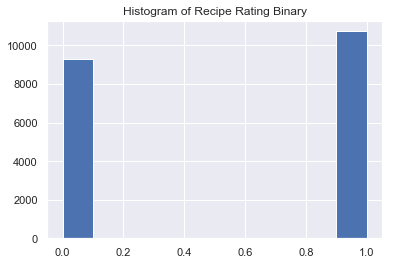

In [68]:
raw_data['rating_cat'].count()

raw_data.rating_cat.hist()
plt.title('Histogram of Recipe Rating Binary')
plt.show()

Ok, so we don't have class inblance with the way I've split the data. Not sure what to do here.

In [89]:
alcohol_counts= raw_data['alcoholic'].value_counts()
rating_cat_counts = raw_data['rating_cat'].value_counts()

## let's try change the epsilon and c values

In [96]:
epsilons = [0.1, 0.2, 0.4, 0.8]

score_epsilon = []


# Declare a logistic regression classifier
for e in epsilons:
    svr = SVR(epsilon=e)
# Fit the model.
    svr.fit(X,Y)
    #append score
    score_epsilon.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'aut

In [99]:
print(score_epsilon)

[-0.2715372570371586, -0.1085110287414992, 0.024574019195715672, -0.0058433996224929174]


Lower value is better. Let's try to optimize in the opposite direction for epsilon

In [100]:
low_epsilons = [0.1, 0.08, 0.04, 0.02]

score_low_epsilon = []


# Declare a logistic regression classifier
for e in low_epsilons:
    svr = SVR(epsilon=e)
# Fit the model.
    svr.fit(X,Y)
    #append score
    score_low_epsilon.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'aut

In [102]:
print(score_low_epsilon)

[-0.2715372570371586, -0.31283418014618825, -0.418813403044235, -0.472723527172029]


Ok, this is looking better. let's further optimize.

In [103]:
lower_epsilons = [0.01, 0.008, 0.004, 0.002]

score_lower_epsilon = []


# Declare a logistic regression classifier
for e in lower_epsilons:
    svr = SVR(epsilon=e)
# Fit the model.
    svr.fit(X,Y)
    #append score
    score_lower_epsilon.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'aut

In [104]:
print(score_lower_epsilon)

[-0.49895134490320836, -0.5045619554376317, -0.5148884159917992, -0.520084703469283]


let's go one more time, since we came this far. looks like values are starting to converge, even though were slightly above a coin flip.

In [105]:
even_lower_epsilons = [0.001, 0.0008, 0.0004]

score_even_lower_epsilon = []


# Declare a logistic regression classifier
for e in even_lower_epsilons:
    svr = SVR(epsilon=e)
# Fit the model.
    svr.fit(X,Y)
    #append score
    score_even_lower_epsilon.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [106]:
print(score_even_lower_epsilon)

[-0.5226208034804782, -0.5232256723076285, -0.5240559946796159]


In [107]:
c_value = [1, 0.5, 0.25]

score_c = []


# Declare a logistic regression classifier
for cval in c_value:
    svr = SVR(C=cval, epsilon=0.0004)
# Fit the model.
    svr.fit(X,Y)
    #append score
    score_c.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [108]:
print(score_c)

[-0.5240559946796159, -0.5065223089379469, -0.41807732234912987]


Going in opposite way..will try increase and then try different kernels.

In [109]:
big_c_value = [1, 1.25, 1.5]

big_score_c = []


# Declare a logistic regression classifier
for cval in big_c_value:
    svr = SVR(C=cval, epsilon=0.0004)
# Fit the model.
    svr.fit(X,Y)
    #append score
    big_score_c.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [110]:
print(big_score_c)

[-0.5240559946796159, -0.5189721965101135, -0.514167036887754]


Model is complete trash and none of this matters!! Let's try changing kernel.

# Optimise for kernel type.

In [114]:
kernel_list = ['linear', 'poly', 'sigmoid']

kernel_score = []

# Declare a logistic regression classifier
for k in kernel_list:
    svr = SVR(kernel=k)
# Fit the model.
    svr.fit(X,Y)
    #append score
    kernel_score.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [115]:
print(kernel_score)

[-0.22372735505011662, -0.43606583743205296, -0.17768617144213159]


Poly works the best here, let's try and optimize this for epsilon.

In [116]:
low_epsilons = [0.1, 0.08, 0.04, 0.02]

score_low_epsilon = []


# Declare a logistic regression classifier
for e in low_epsilons:
    svr = SVR(epsilon=e, kernel='poly')
# Fit the model.
    svr.fit(X,Y)
    #append score
    score_low_epsilon.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'aut

In [117]:
print(score_low_epsilon)

[-0.43606583743205296, -0.4909080551643994, -0.6086305754358563, -0.6725962978364501]


let's further optimize for epsilon.

In [119]:
even_lower_epsilons = [0.001, 0.0008, 0.0004]

score_even_lower_epsilon = []


# Declare a logistic regression classifier
for e in even_lower_epsilons:
    svr = SVR(epsilon=e, kernel='poly' )
# Fit the model.
    svr.fit(X,Y)
    #append score
    score_even_lower_epsilon.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [120]:
print(score_even_lower_epsilon)

[-0.7378789208549938, -0.7382307850775348, -0.7399460602582124]


Values are converging, let's finally try to optimize for c using the poly kernel and epsilon = 0.0004.

In [121]:
big_c_value = [1, 1.25, 1.5]

big_score_c = []


# Declare a logistic regression classifier
for cval in big_c_value:
    svr = SVR(C=cval, kernel='poly',epsilon=0.0004)
# Fit the model.
    svr.fit(X,Y)
    #append score
    big_score_c.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [122]:
print(big_score_c)

[-0.7399460602582124, -0.7302956367699482, -0.7206844564963113]


no difference - let's try reducing.

In [10]:
lower_c_value = [1, 0.75, 0.5]

lower_score_c = []


# Declare a logistic regression classifier
for cval in lower_c_value:
    svr = SVR(C=cval, kernel='poly',epsilon=0.0004)
# Fit the model.
    svr.fit(X,Y)
    #append score
    lower_score_c.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


KeyboardInterrupt: 

In [124]:
print(lower_score_c)

[-0.7399460602582124, -0.7484983162091683, -0.7580421519983694]


one last time then let's cross val.

In [12]:
evenlower_c_value = [0.4, 0.2, 0.1]

evenlower_score_c = []


# Declare a logistic regression classifier
for cval in evenlower_c_value:
    svr = SVR(C=cval, kernel='poly',epsilon=0.0004)
# Fit the model.
    svr.fit(X,Y)
    #append score
    evenlower_score_c.append(svr.score(X, Y))

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [13]:
print(evenlower_score_c)

[-0.7653510761693948, -0.7986476287618496, -0.8250654560084334]


Optimal settings for this model are kernel=poly, epsilon=0.0004 and c=0.1

#  Final model and cross validation.

In [14]:
svr = SVR(C=0.1, kernel='poly',epsilon=0.0004)
X = raw_data_abbr.sample(frac=0.6, replace=True, random_state=1)
Y = raw_data.rating_cat.sample(frac=0.6, replace=True, random_state=1)
svr.fit(X,Y)

svr.score(X, Y)

from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'aut

array([-0.81113005, -0.88218215, -0.81538352, -0.82118137, -0.82431052])

Much better. With some feature optimization we could get this higher.

Didn't notice the negative there, turns out this model is terrible.

# back to the drawing board

# Hypothesis - the only thing that can be tested here is if something is 5 stars. Let's check...

In [44]:
#let's try classifying just the top tier review
raw_data['fivestar_rating'] = np.where(raw_data['rating'] >= 4.95, 1, 0)
raw_data.fivestar_rating.value_counts()

0    17333
1     2719
Name: fivestar_rating, dtype: int64

In [48]:
correlation_matrix = raw_data.corr()

In [51]:
print(correlation_matrix['fivestar_rating'].abs().sort_values(ascending=False).head(15))

fivestar_rating    1.000000
5star_rating       1.000000
good_rating        1.000000
rating             0.379742
rating_cat         0.368871
vegetable          0.065349
backyard bbq       0.064712
low cholesterol    0.063938
sauté              0.060258
drink              0.059575
bake               0.058503
quick & easy       0.058359
gourmet            0.057693
alcoholic          0.055983
chile pepper       0.055078
Name: fivestar_rating, dtype: float64


In [52]:
newX = raw_data[['vegetable', 'backyard bbq', 'low cholesterol', 'sauté', 'drink', 'bake', 'quick & easy', 'gourmet', 'alcoholic', 'chile pepper']]

In [45]:
newy=raw_data['fivestar_rating']

In [56]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(newX, newy)

svc.score(newX, newy)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8644025533612607

In [55]:
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X_train, Y_train, cv=5)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'aut

array([0.86315789, 0.86311998, 0.86311998, 0.86311998, 0.86311998])

Lesson learned - SVM is good for predicting/detecting fringe cases....may not be good for splitting a messy dataset like this in half and accurately predicting. When you use SVM, be specific about what you're trying to pick out. 